In [7]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *
from soledge.wrapper_class import SOLEDGEcase

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [8]:
db = CaseDB()

toload = [ 
    dict(name="1e19", id="d45a-d42acb_1e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="3e19", id="d44a-d42acb_3e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19_lores", id="t9b-nonortho_xpoint_afn", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case d45a-d42acb_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:25:51, dmp file date 09/10/2024, 12:44:06


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d44a-d42acb_3e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:27:45, dmp file date 09/10/2024, 12:48:53


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case t9b-nonortho_xpoint_afn
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 14:20:48, dmp file date 09/03/2024, 12:28:50


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Read SOLEDGE

In [9]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    # "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    # "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    # "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    # "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    print(name)
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Make sure M is always positive
for region in ['inner_lower', 'outer_lower', 'outer_upper', 'inner_upper']:
    for name in soledgecases:
        sl[name].regions[region]["M"] = np.abs(sl[name].regions[region]["M"])


tightwall_1e19
tightwall_2e19
tightwall_3e19


# Read SOLPS

In [10]:
solpscases = {

    # "tightwall_noD2_1e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\From\Matteo\2024-11-01 - 1e19 2e19 3e19 no viscosity, spectra\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_spectra_20241106\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    "tightwall_noD2_1e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    
    "tightwall_noD2_1e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi_spectra\xxxx.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",

}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # _ = read_last10s(solpscases[name], save = True)
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [11]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    ds = cs[name].ds
    # ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    # ds = reverse_pfr_fluxes(ds)

1e19
2e19
3e19
2e19_lores


# Lineplots

## Pressures

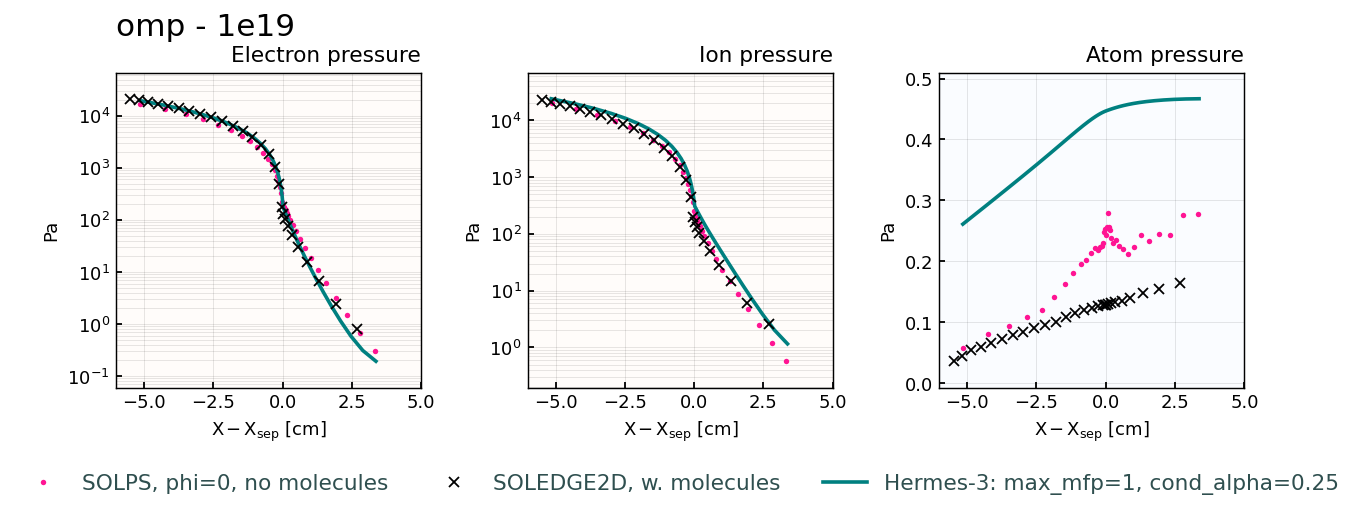

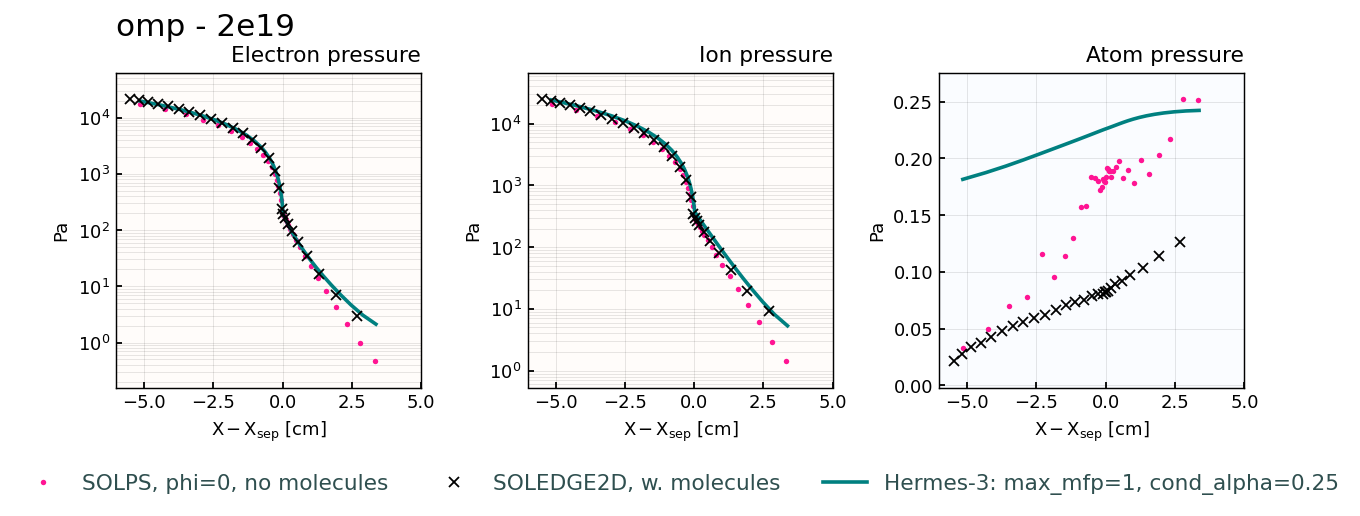

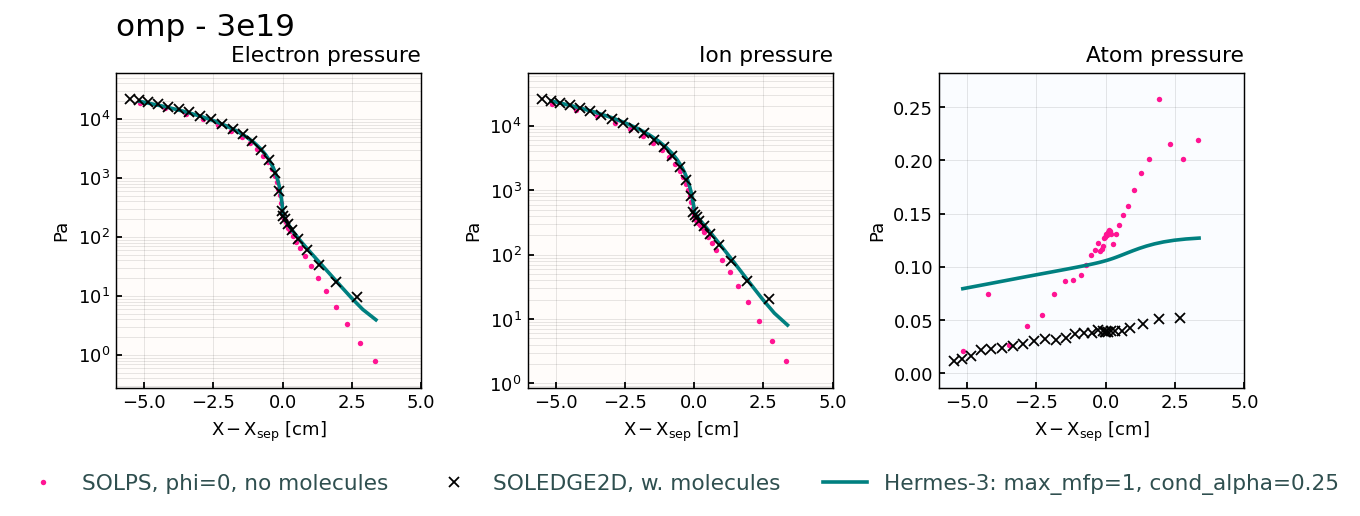

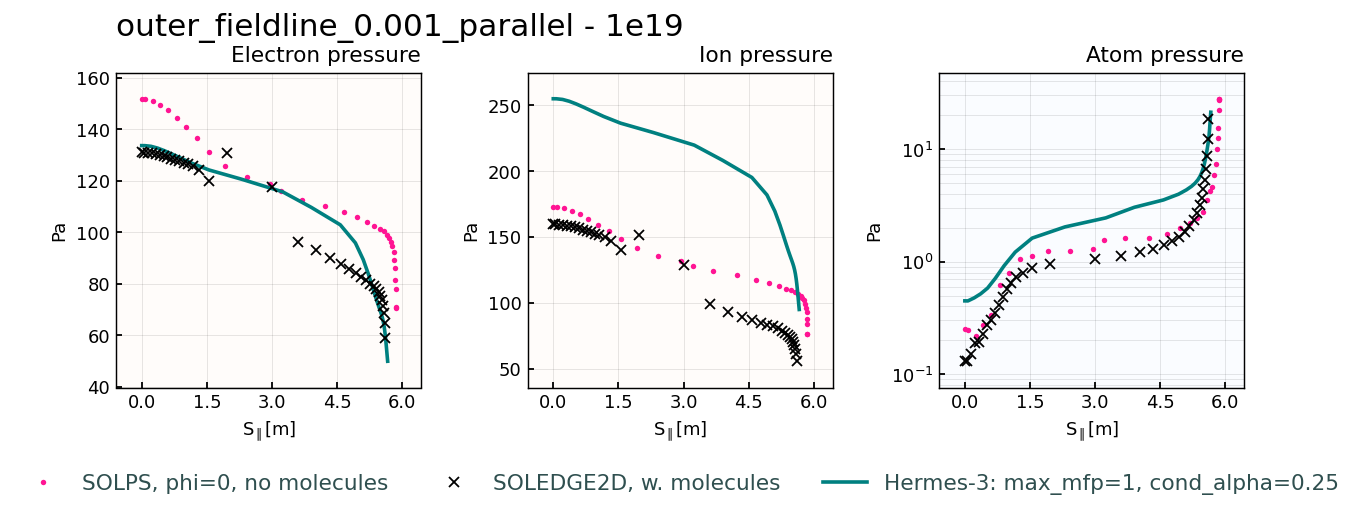

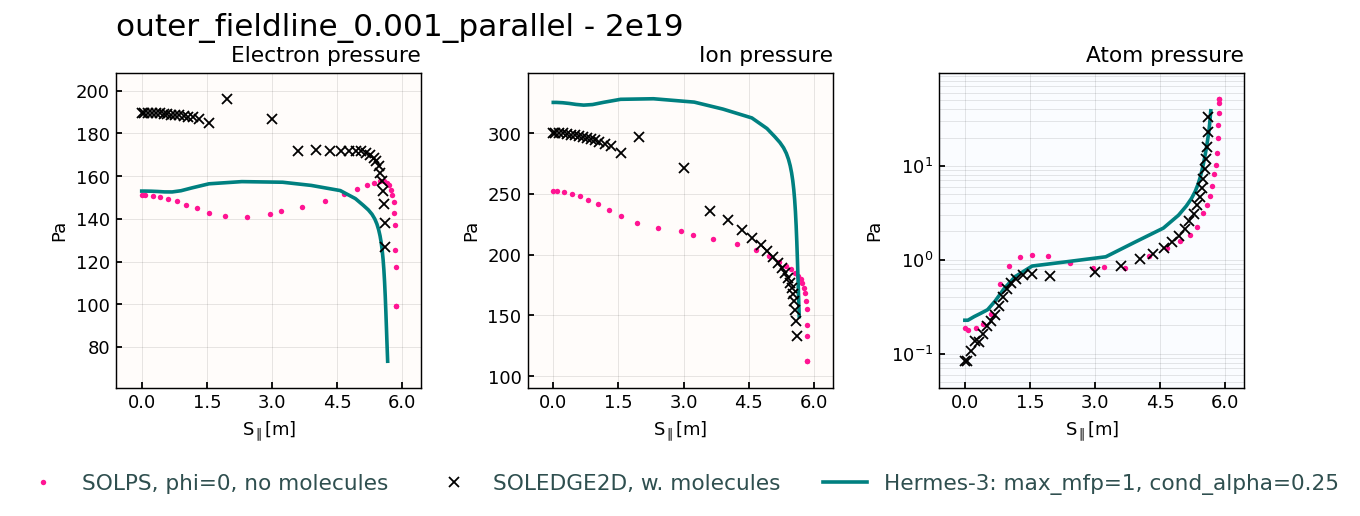

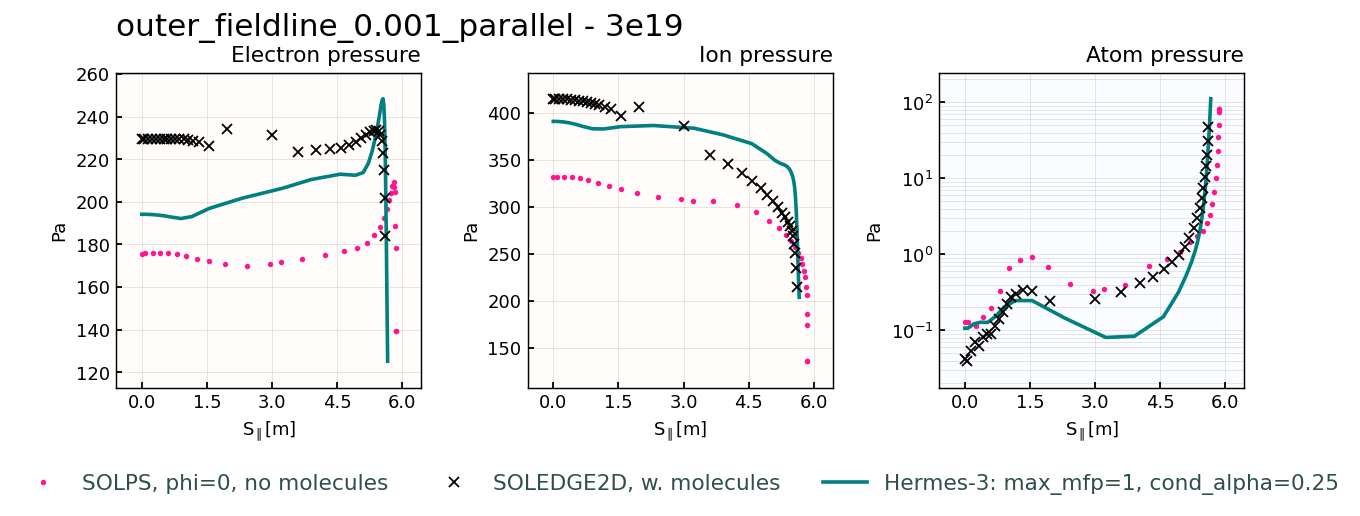

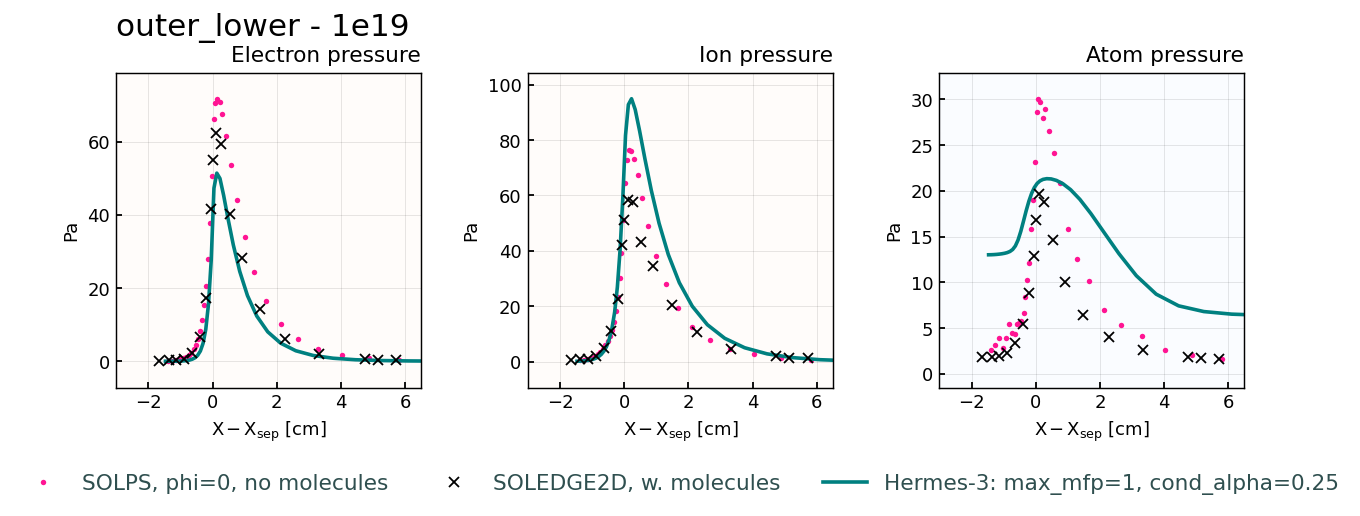

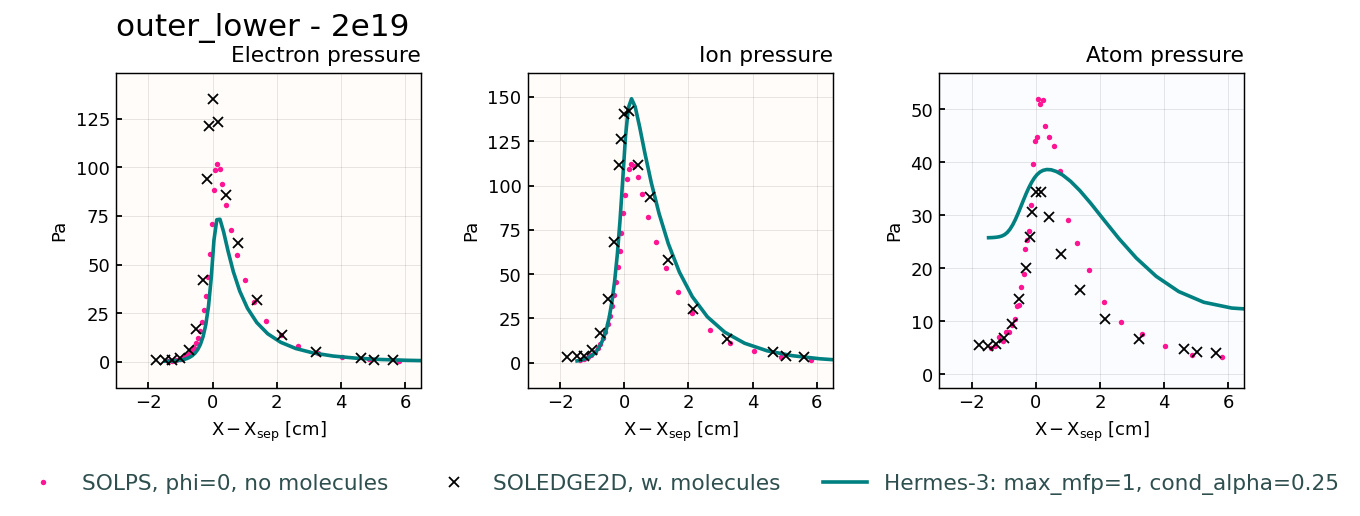

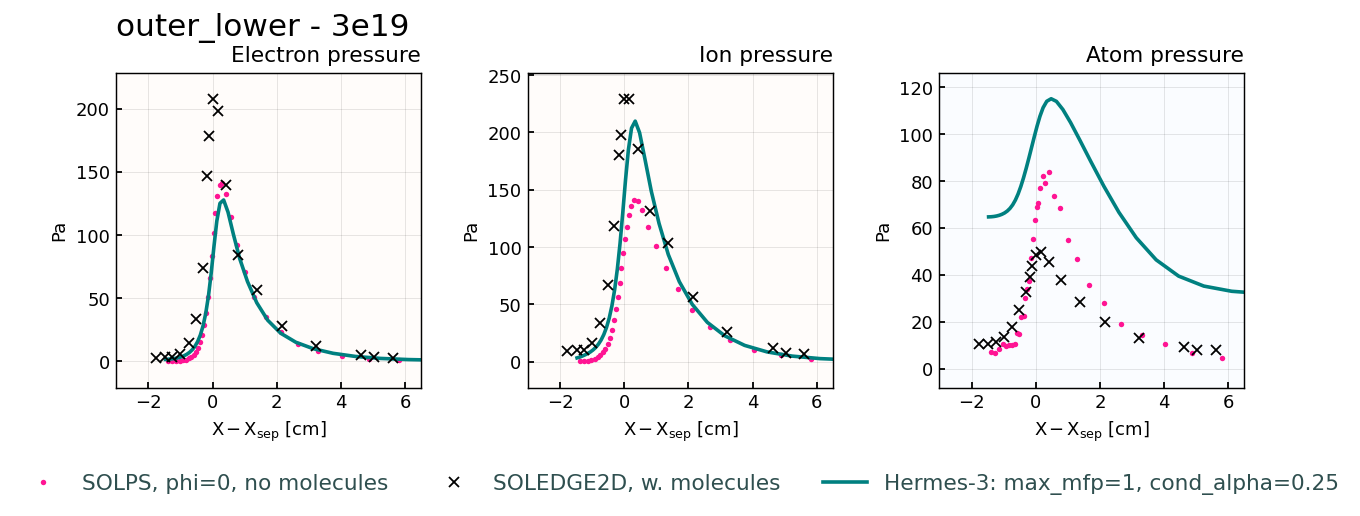

In [6]:
               
plot_by_region(
    cases = { 

        "SOLPS, phi=0, no molecules" : dict(name="tightwall_noD2_1e19_zerophi", color="deeppink"),
        "SOLEDGE2D, w. molecules" : dict(name="tightwall_1e19", color="black"),
        r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(name='1e19', color = "teal"),

    },
    regions = ["omp", "outer_fieldline_0.001_parallel", "outer_lower"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta", "M"],
    params = ["Pe", "Pd+", "Pa"],
    # params = ["Nn", "Na", "Nm", "Pn", "Pa", "Pm", "Tn", "Ta", "Tm"],
    data_dicts = {"SOLPS":sp, "SOLEDGE2D":sl, "Hermes-3":hr},
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False)

# Upper divertors

In [ ]:
     
plot_by_region(
    cases = { 

        "SOLPS, phi=0, no molecules" : dict(name="tightwall_noD2_1e19_zerophi", color="deeppink"),
        "SOLEDGE2D, w. molecules" : dict(name="tightwall_1e19", color="black"),
        r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(name='1e19', color = "teal"),

    },
    regions = ["omp", "outer_fieldline_0.001_parallel", "outer_lower"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta", "M"],
    params = ["Pe", "Pd+", "Pa"],
    # params = ["Nn", "Na", "Nm", "Pn", "Pa", "Pm", "Tn", "Ta", "Tm"],
    data_dicts = {"SOLPS":sp, "SOLEDGE2D":sl, "Hermes-3":hr},
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False)

# Core ionisation / transport

In [7]:
solpscases.keys()

dict_keys(['tightwall_noD2_1e19_zerophi', 'tightwall_noD2_2e19_zerophi', 'tightwall_noD2_3e19_zerophi', 'tightwall_noD2_1e19_zerophi_spectra', 'tightwall_noD2_2e19_zerophi_spectra', 'tightwall_noD2_3e19_zerophi_spectra'])

## Absolute plots

### Ionisation

NameError: name 'casestore' is not defined

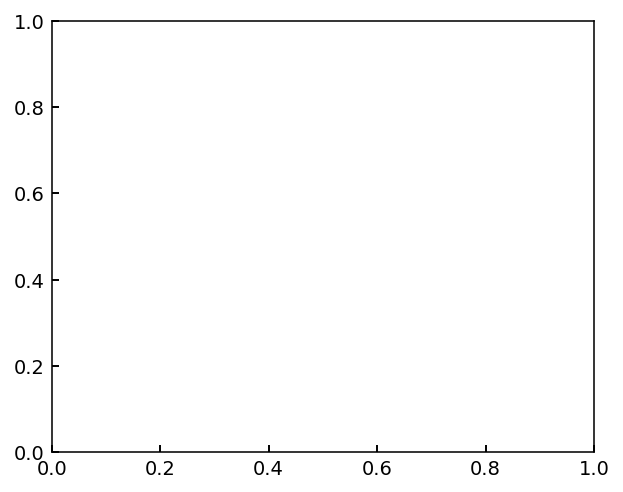

In [6]:
# rate = a.amjuel_data["H.2 3.1.8"]
# omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
# dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

# sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
# rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    # omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    # dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    # sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    # rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, omp["Sd+_iz"], label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.4_2.1.5_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.4_2.1.5_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Ionisation")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")
ax.set_yscale("log")


### Flux

Text(0.5, 1.0, 'Midplane radial neutral advection')

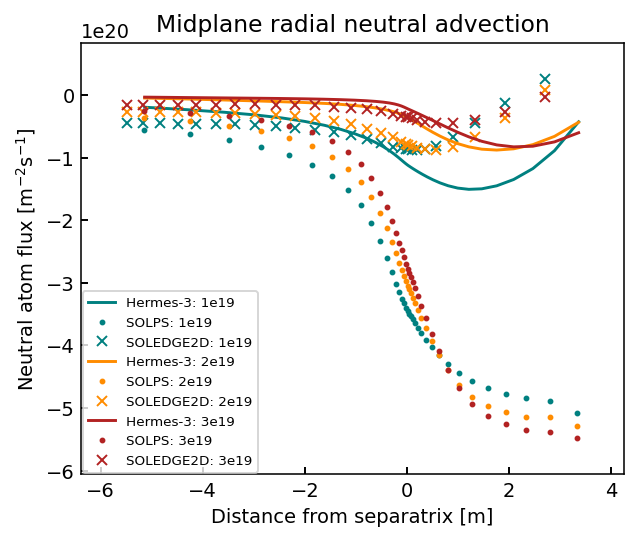

In [6]:
fig, ax = plt.subplots()

colors = ["teal", "darkorange", "firebrick"]

for i, dens in enumerate(["1e19", "2e19", "3e19"]):

    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
    solps = spc.get_1d_radial_data(["rfluxa"], region = "omp")
    kwargs = dict(lw = 1.5)
    
    # Hermes-3
    ds = cs[dens].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    
    hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz"], "omp")
    ax.plot(hrdf["Srad"]*100, hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) , **kwargs, c = colors[i], label = f"Hermes-3: {dens}")

    # SOLPS
    ax.plot(solps.dist*100, solps["rfluxa"], label = f"SOLPS: {dens}", marker = "o", ms = 2, c = colors[i], lw = 0, alpha = 1)

    # SOLEDGE
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
    df = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
    df["NVxn"] = df["vxni"] * df["Nni"]
    ax.plot(df["dist"]*100, df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.0, label = f"SOLEDGE2D: {dens}", c = colors[i])

ax.legend(fontsize = "x-small")

ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom flux [$m^{-2}s^{-1}$]")
ax.set_title("Midplane radial neutral advection")

### Velocity

Text(0.5, 1.0, 'Midplane radial neutral velocity')

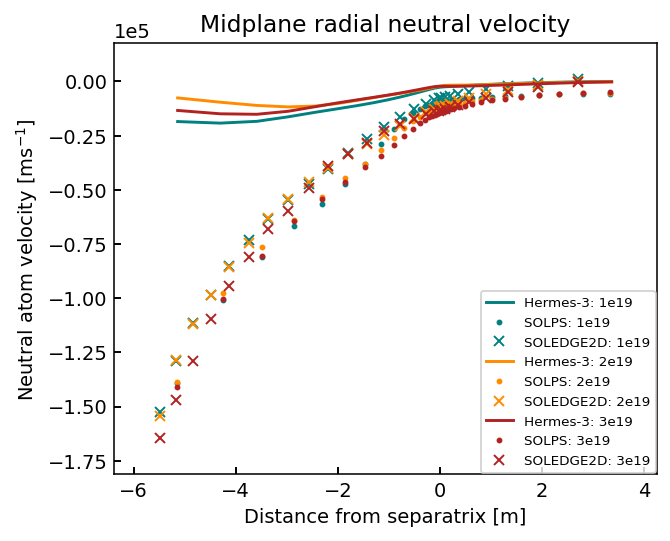

In [7]:
fig, ax = plt.subplots()

colors = ["teal", "darkorange", "firebrick"]

for i, dens in enumerate(["1e19", "2e19", "3e19"]):


    # Hermes-3
    ds = cs[dens].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    
    hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd"], "omp")
    ax.plot(hrdf["Srad"]*100, hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) / hrdf["Nd"] , lw = 1.5, c = colors[i], label = f"Hermes-3: {dens}")

    # SOLPS
    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
    solps = spc.get_1d_radial_data(["rfluxa", "Na"], region = "omp")
    ax.plot(solps.dist*100, solps["rfluxa"] / solps["Na"], label = f"SOLPS: {dens}", marker = "o", ms = 2, c = colors[i], lw = 0, alpha = 1)

    # SOLEDGE
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
    df = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
    ax.plot(df["dist"]*100, df["vxni"], lw=0, marker = "x", ms = 5, markeredgewidth=1.0, label = f"SOLEDGE2D: {dens}", c = colors[i])

ax.legend(fontsize = "x-small")

ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom velocity [$ms^{-1}$]")
ax.set_title("Midplane radial neutral velocity")

### Density

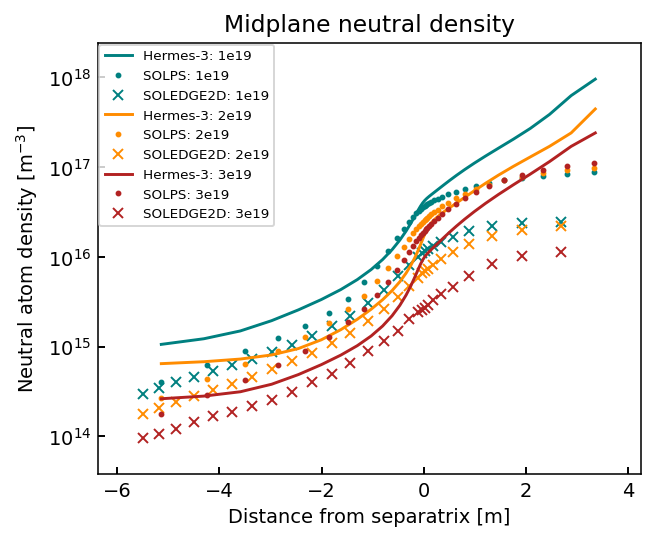

In [10]:
fig, ax = plt.subplots()

colors = ["teal", "darkorange", "firebrick"]

for i, dens in enumerate(["1e19", "2e19", "3e19"]):


    # Hermes-3
    ds = cs[dens].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    
    hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd"], "omp")
    ax.plot(hrdf["Srad"]*100, hrdf["Nd"] , lw = 1.5, c = colors[i], label = f"Hermes-3: {dens}")

    # SOLPS
    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
    solps = spc.get_1d_radial_data(["rfluxa", "Na"], region = "omp")
    ax.plot(solps.dist*100, solps["Na"], label = f"SOLPS: {dens}", marker = "o", ms = 2, c = colors[i], lw = 0, alpha = 1)

    # SOLEDGE
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
    df = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
    ax.plot(df["dist"]*100, df["Nni"], lw=0, marker = "x", ms = 5, markeredgewidth=1.0, label = f"SOLEDGE2D: {dens}", c = colors[i])

ax.legend(fontsize = "x-small")

ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom density [$m^{-3}$]")
ax.set_title("Midplane neutral density")
ax.set_yscale("log")

### Velocity reconstructed
Reconstruct v_perp using SOLPS pressure

Text(0.5, 1.0, 'Midplane radial neutral velocity')

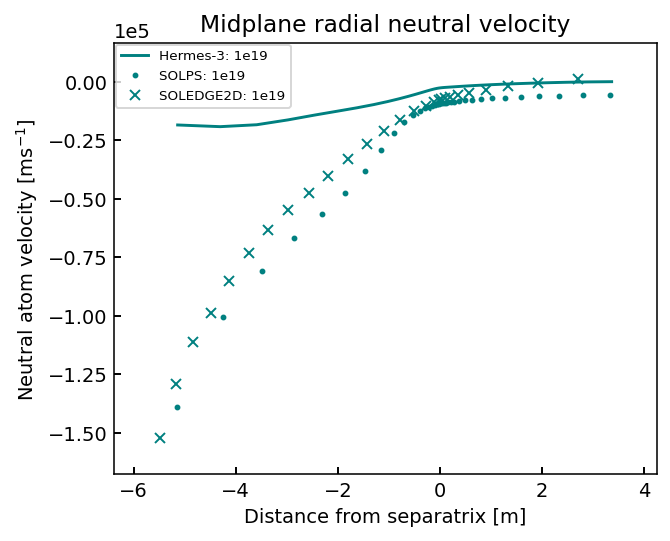

In [59]:
fig, ax = plt.subplots()

colors = ["teal", "darkorange", "firebrick"]

# for i, dens in enumerate(["1e19", "2e19", "3e19"]):

dens = "1e19"
i = 0


# Hermes-3
ds = cs[dens].ds
if "t" in ds.dims: ds = ds.isel(t=-1)

hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd", "Pd", "Dnnd", "particle_flux_factor_d"], "omp")
hrdf["V"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) / hrdf["Nd"]
ax.plot(hrdf["Srad"]*100,  hrdf["V"], lw = 1.5, c = colors[i], label = f"Hermes-3: {dens}")

# SOLPS
spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
solps = spc.get_1d_radial_data(["rfluxa", "Na", "Pa"], region = "omp")
solps["V"] = solps["rfluxa"] / solps["Na"]
ax.plot(solps.dist*100, solps["V"], label = f"SOLPS: {dens}", marker = "o", ms = 2, c = colors[i], lw = 0, alpha = 1)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
soledge = slc.get_1d_radial_data(["vxni", "Nni", "Nmi", "Pni"])
ax.plot(soledge["dist"]*100, soledge["vxni"], lw=0, marker = "x", ms = 5, markeredgewidth=1.0, label = f"SOLEDGE2D: {dens}", c = colors[i])

ax.legend(fontsize = "x-small")

ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom velocity [$ms^{-1}$]")
ax.set_title("Midplane radial neutral velocity")

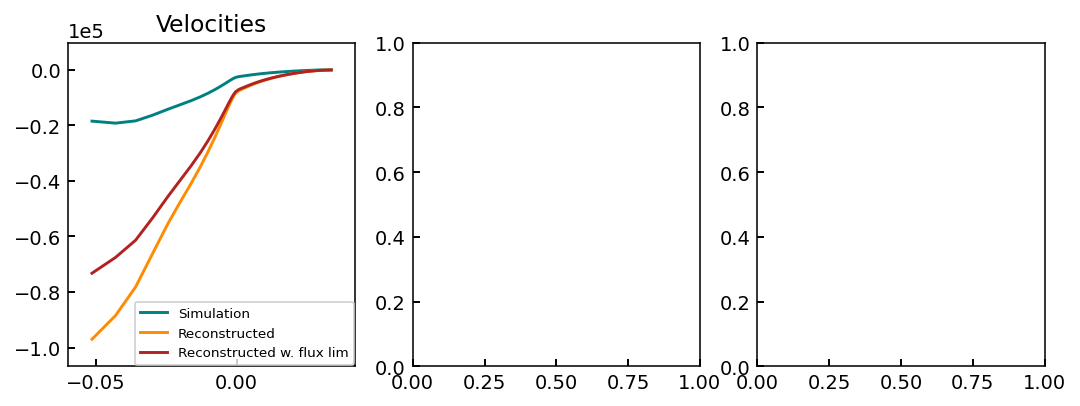

In [68]:
hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd", "Pd", "Dnnd", "particle_flux_factor_d"], "omp")

hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"])
hrdf["V_hermes"] = hrdf["flux_hermes"] / hrdf["Nd"]

hrdf["Grad_Pa_hermes"] = np.gradient(hrdf["Pd"], hrdf["Srad"])
hrdf["V_hermes_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"]
hrdf["V_hermes_fluxlim_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"] * hrdf["particle_flux_factor_d"]


fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")
ax.plot(hrdf["Srad"], hrdf["V_hermes"], label = "Simulation")
ax.plot(hrdf["Srad"], hrdf["V_hermes_reconstruct"], label = "Reconstructed")
ax.plot(hrdf["Srad"], hrdf["V_hermes_fluxlim_reconstruct"], label = "Reconstructed w. flux lim")
ax.legend(fontsize = "x-small")

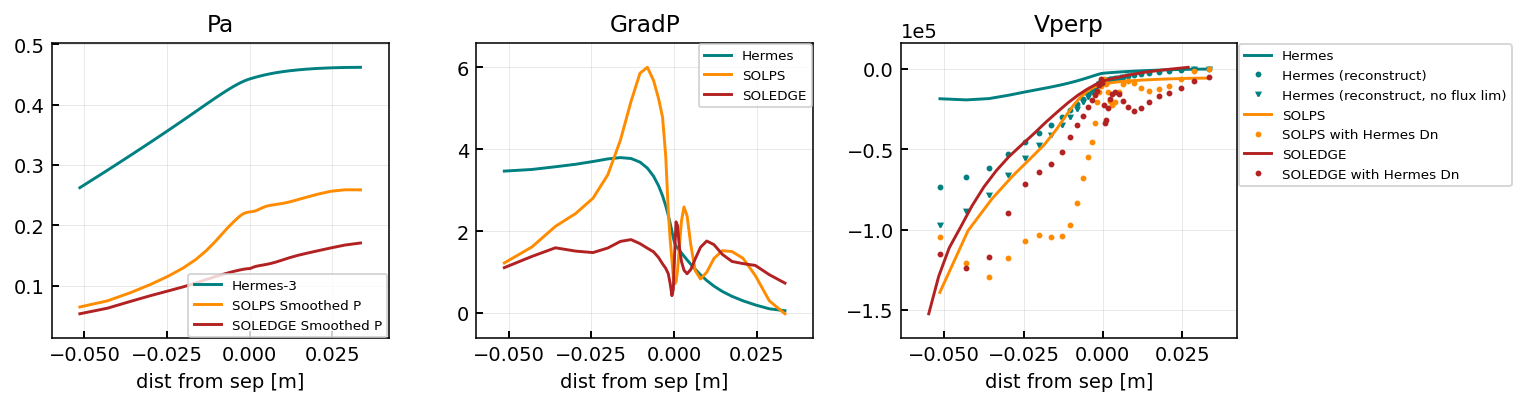

: 

In [ ]:


hrdf["Pa_solps"] = scipy.interpolate.interp1d(solps.dist, solps["Pa"], fill_value="extrapolate")(hrdf["Srad"])
hrdf["Pa_solps_smooth"] = scipy.ndimage.gaussian_filter1d(hrdf["Pa_solps"], sigma=1)
hrdf["Grad_Pa_solps"] = np.gradient(hrdf["Pa_solps_smooth"], hrdf["Srad"])
hrdf["V_solps_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_solps"] / hrdf["Pa_solps_smooth"] * hrdf["particle_flux_factor_d"]


slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
soledge = slc.get_1d_radial_data(["vxni", "Nni", "Nmi", "Pni"])

hrdf["Pa_soledge"] = scipy.interpolate.interp1d(soledge["dist"], soledge["Pni"], fill_value="extrapolate")(hrdf["Srad"])
hrdf["Pa_soledge_smooth"] = scipy.ndimage.gaussian_filter1d(hrdf["Pa_soledge"], sigma=1)
hrdf["Grad_Pa_soledge"] = np.gradient(hrdf["Pa_soledge_smooth"], hrdf["Srad"])
hrdf["V_soledge_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_soledge"] / hrdf["Pa_soledge_smooth"] * hrdf["particle_flux_factor_d"]

hrdf

fig, axes = plt.subplots(1,3, figsize = (11,3))
ax = axes[0]
ax.set_title("Pa")
ax.plot(hrdf["Srad"], hrdf["Pd"], label = "Hermes-3")
# ax.plot(hrdf["Srad"], hrdf["Pa_solps"], label = "SOLPS Raw P")
ax.plot(hrdf["Srad"], hrdf["Pa_solps_smooth"], label = "SOLPS Smoothed P")
ax.plot(hrdf["Srad"], hrdf["Pa_soledge_smooth"], label = "SOLEDGE Smoothed P")
ax.legend(fontsize = "x-small")

ax = axes[1]
ax.set_title("GradP")
ax.plot(hrdf["Srad"], hrdf["Grad_Pa_hermes"], label = "Hermes")
ax.plot(hrdf["Srad"], hrdf["Grad_Pa_solps"], label = "SOLPS")
ax.plot(hrdf["Srad"], hrdf["Grad_Pa_soledge"], label = "SOLEDGE")
ax.legend(fontsize = "x-small")

ax = axes[2]
ax.set_title("Vperp")
ax.plot(hrdf["Srad"], hrdf["V_hermes"], label = "Hermes")
ax.plot(hrdf["Srad"], hrdf["V_hermes_fluxlim_reconstruct"], "o", label = "Hermes (reconstruct)", c = "teal", ms = 2)
ax.plot(hrdf["Srad"], hrdf["V_hermes_reconstruct"], "v", label = "Hermes (reconstruct, no flux lim)", c = "teal", ms = 2)




ax.plot(solps["dist"], solps["V"], label = "SOLPS", c = "C1")
ax.plot(hrdf["Srad"], hrdf["V_solps_reconstruct"], "o", label = "SOLPS with Hermes Dn", c = "C1", ms = 2)
ax.plot(soledge["dist"], soledge["vxni"], label = "SOLEDGE", c = "C2")
ax.plot(hrdf["Srad"], hrdf["V_soledge_reconstruct"], "o", label = "SOLEDGE with Hermes Dn", c = "C2", ms = 2)
ax.legend(bbox_to_anchor = (1,1), loc = "upper left", fontsize = "x-small")

for ax in axes:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    ax.grid()
    ax.set_xlabel("dist from sep [m]")
fig.tight_layout()
# ax.plot(hrdf["Srad"], hrdf["Pa_solps_smooth"], label = "Smoothed P")

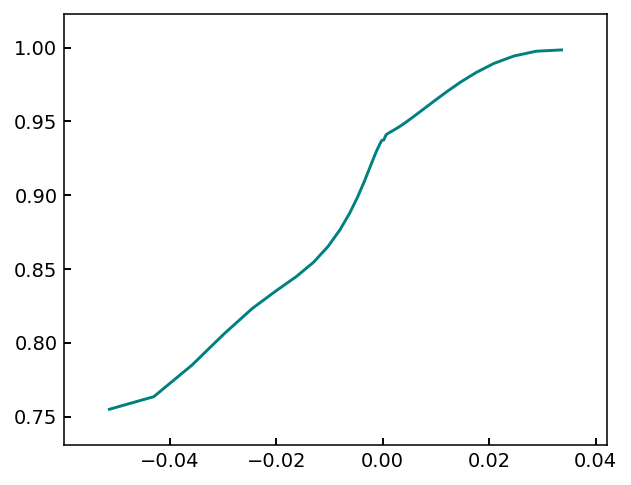

## Relative plots

In [11]:
hrdfs = {}
spdfs = {}
sldfs = {}

for i, dens in enumerate(["1e19", "2e19", "3e19"]):

    # Hermes-3
    ds = cs[dens].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd"], "omp")
    hrdf["Gax"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"])
    hrdf["Vax"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) / hrdf["Nd"]
    hrdf["Na"] = hrdf["Nd"]
    hrdf["dist"] = hrdf["Srad"] * 100
    hrdfs[dens] = hrdf.copy()
    
    # SOLPS
    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
    spdf = spc.get_1d_radial_data(["rfluxa", "Na"], region = "omp")
    spdf["Gax"] = spdf["rfluxa"]
    spdf["Vax"] = spdf["rfluxa"] / spdf["Na"]
    spdf["dist"] *=100
    spdfs[dens] = spdf.copy()

    # SOLEDGE
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])
    sldf = slc.get_1d_radial_data(["vxni", "Nni", "Nmi"])
    sldf["Gax"] = sldf["vxni"] * sldf["Nni"]
    sldf["Vax"] = sldf["vxni"]
    sldf["Na"] = sldf["Nni"]
    sldf["dist"] *=100
    sldfs[dens] = sldf.copy()

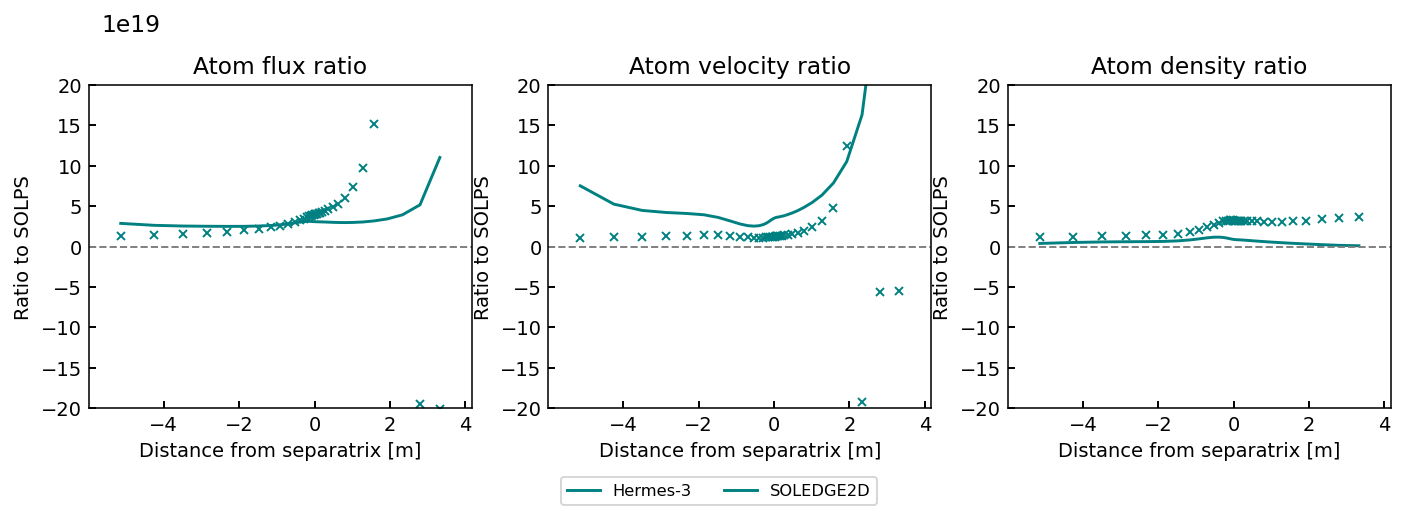

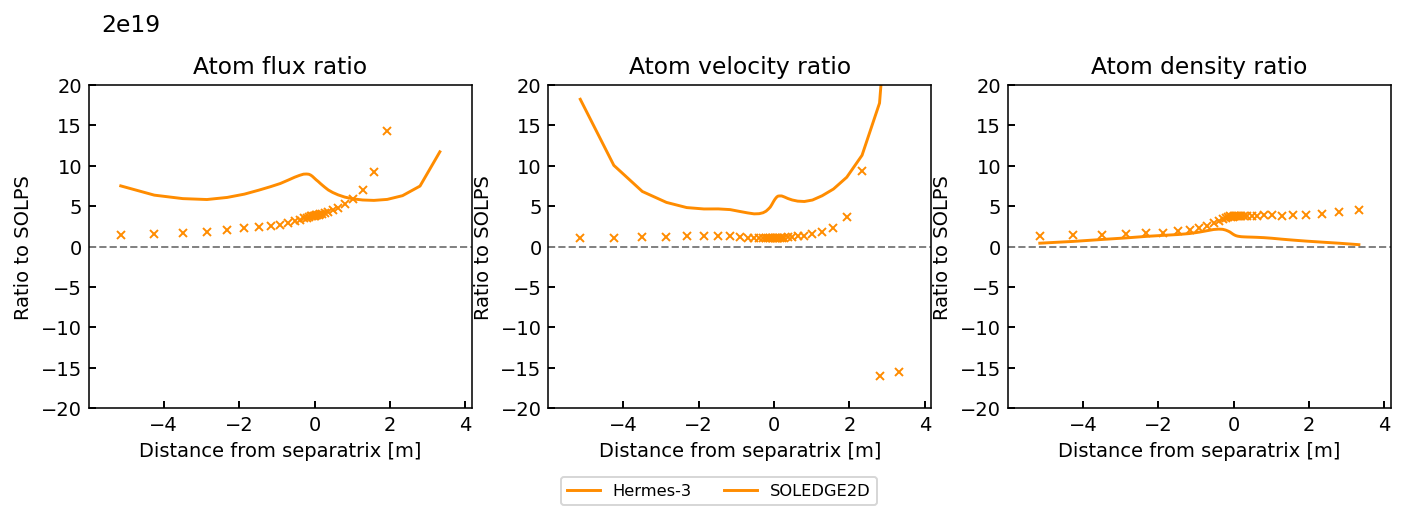

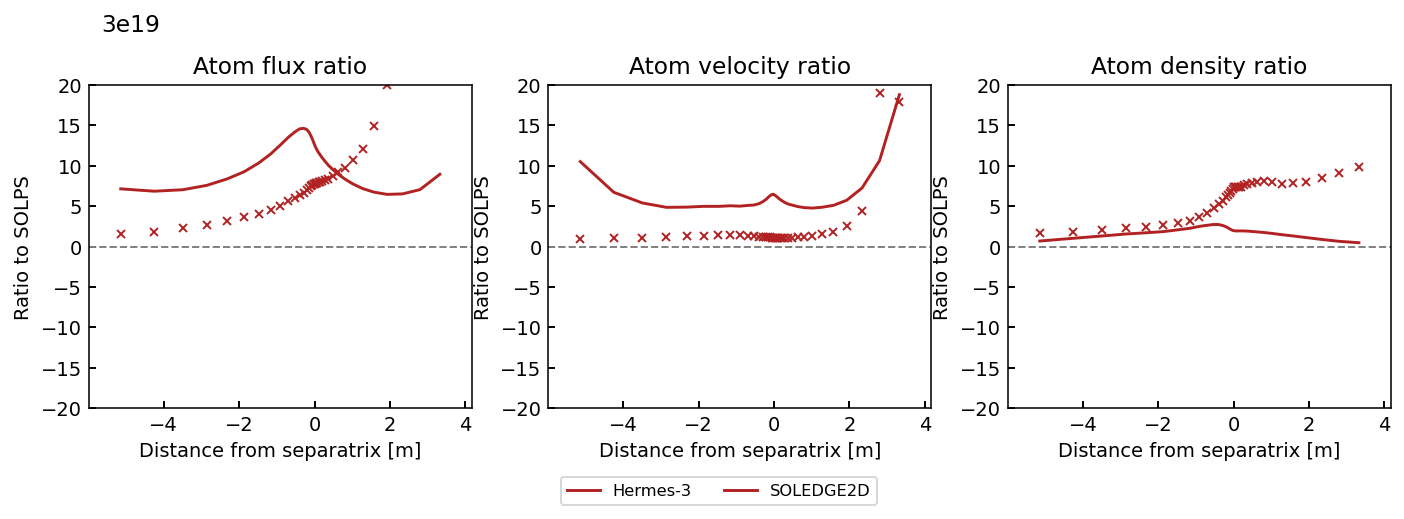

In [11]:
colors = ["teal", "darkorange", "firebrick"]

for i, dens in enumerate(["1e19", "2e19", "3e19"]):

    df = pd.DataFrame()
    hrdf = hrdfs[dens]
    spdf = spdfs[dens]
    sldf = sldfs[dens]

    df["dist"] = spdf["dist"]
    df["Gax_solps"] = spdf["Gax"]
    df["Gax_hermes"] = np.interp(spdf["dist"], hrdf["dist"], hrdf["Gax"])
    df["Gax_soledge"] = np.interp(spdf["dist"], sldf["dist"], sldf["Gax"])
    df["Gax_ratio_hermes"] = spdf["Gax"] / df["Gax_hermes"]
    df["Gax_ratio_soledge"] = spdf["Gax"] / df["Gax_soledge"]
    df["Na_solps"] = spdf["Na"]
    df["Na_hermes"] = np.interp(spdf["dist"], hrdf["dist"], hrdf["Na"])
    df["Na_soledge"] = np.interp(spdf["dist"], sldf["dist"], sldf["Na"])
    df["Na_ratio_hermes"] = spdf["Na"] / df["Na_hermes"]
    df["Na_ratio_soledge"] = spdf["Na"] / df["Na_soledge"]
    df["Vax_solps"] = spdf["Vax"]
    df["Vax_hermes"] = np.interp(spdf["dist"], hrdf["dist"], hrdf["Vax"])
    df["Vax_soledge"] = np.interp(spdf["dist"], sldf["dist"], sldf["Vax"])
    df["Vax_ratio_hermes"] = spdf["Vax"] / df["Vax_hermes"]
    df["Vax_ratio_soledge"] = spdf["Vax"] / df["Vax_soledge"]

    hrstyle = dict(lw = 1.5, c = colors[i])
    slstyle = dict(marker = "x", markeredgewidth = 1, ms = 4, c = colors[i], lw = 0)
    spstyle = dict(marker = "o", markeredgewidth = 1, ms = 4, c = colors[i], lw = 0)

    fig, axes = plt.subplots(1,3, figsize = (12, 3))
    fig.suptitle(dens, x = 0.15, y = 1.05)
    ax = axes[0]
    ax.set_title("Atom flux ratio")
    ax.plot(df["dist"], df["Gax_ratio_hermes"], label = "Hermes-3", **hrstyle)
    ax.plot(df["dist"], df["Gax_ratio_soledge"], **slstyle)
    ax = axes[1]
    ax.set_title("Atom velocity ratio")
    ax.plot(df["dist"], df["Vax_ratio_hermes"], label = "SOLEDGE2D", **hrstyle)
    ax.plot(df["dist"], df["Vax_ratio_soledge"], **slstyle)
    ax = axes[2]
    ax.set_title("Atom density ratio")
    ax.plot(df["dist"], df["Na_ratio_hermes"], **hrstyle)
    ax.plot(df["dist"], df["Na_ratio_soledge"], **slstyle)

    for ax in axes:
        
        
        xlims = ax.get_xlim()
        ax.hlines(0, *xlims, lw = 1, ls = "--", colors = "grey")
        ax.set_xlim(xlims)
        ax.set_ylim(-20,20)
        ax.set_xlabel("Distance from separatrix [m]")
        ax.set_ylabel("Ratio to SOLPS")
        
    fig.legend(bbox_to_anchor = (0.5, -0.05), loc = "upper center", ncol = 2, fontsize = "small")


    # fig, axes = plt.subplots(1,3, figsize = (12, 4))
    # ax = axes[0]
    # ax.set_title("Atom flux")
    # ax.plot(df["dist"], df["Gax_hermes"], **hrstyle)
    # ax.plot(df["dist"], df["Gax_solps"], **spstyle)
    # ax.plot(df["dist"], df["Gax_soledge"], **slstyle)
    # ax = axes[1]
    # ax.set_title("Atom velocity")
    # ax.plot(df["dist"], df["Vax_hermes"], **hrstyle)
    # ax.plot(df["dist"], df["Vax_solps"], **spstyle)
    # ax.plot(df["dist"], df["Vax_soledge"], **slstyle)
    # ax = axes[2]
    # ax.set_title("Atom density")
    # ax.plot(df["dist"], df["Na_hermes"], **hrstyle)
    # ax.plot(df["dist"], df["Na_solps"], **spstyle)
    # ax.plot(df["dist"], df["Na_soledge"], **slstyle)
    # [ax.legend() for ax in axes]

## Molecules

In [ ]:
fig, ax = plt.subplots()



# 2D vector plots

## SOLEDGE2D

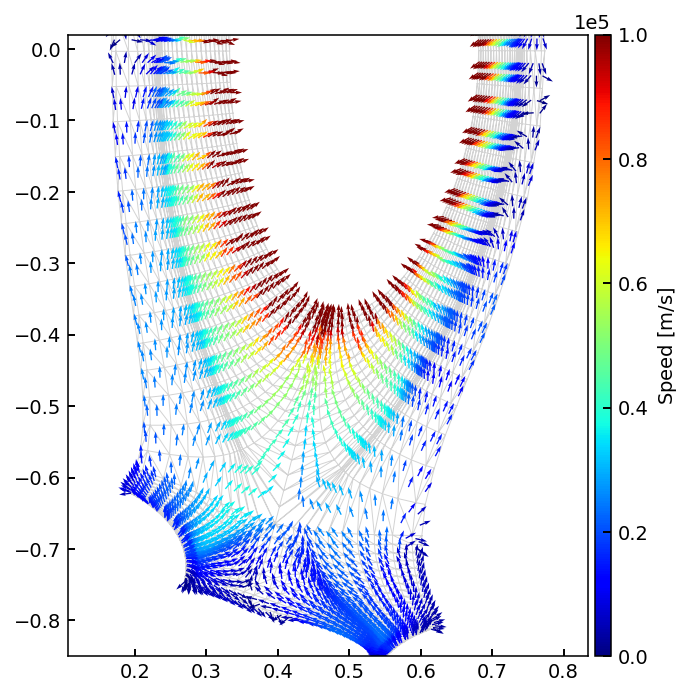

In [12]:
self = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
fig, ax = plt.subplots(figsize = (5,15))
ax.set_aspect("equal")
ax.set_ylim(-0.85, 0.02)
self.plot_neutral_vectors(ax = ax, vmin = 0, vmax = 1e5)


## SOLPS

In [13]:
from gridtools.solps_python_scripts.read_triangle_mesh import read_triangle_mesh

for name in solpscases:
    path = solpscases[name]
    read_triangle_mesh(where = path, save = True)

read_ft33: assuming ntrfrm = 0.
read_ft33: assuming ntrfrm = 0.
read_ft33: assuming ntrfrm = 0.
read_ft33: assuming ntrfrm = 0.
read_ft33: assuming ntrfrm = 0.
read_ft33: assuming ntrfrm = 0.


## Velocity vectors

In [12]:

spc = SOLPScase(solpscases[f"tightwall_noD2_3e19_zerophi_spectra"])
spc.plot_neutral_vectors(ax = axes[1,i], flux = False, **kwargs)

NameError: name 'axes' is not defined

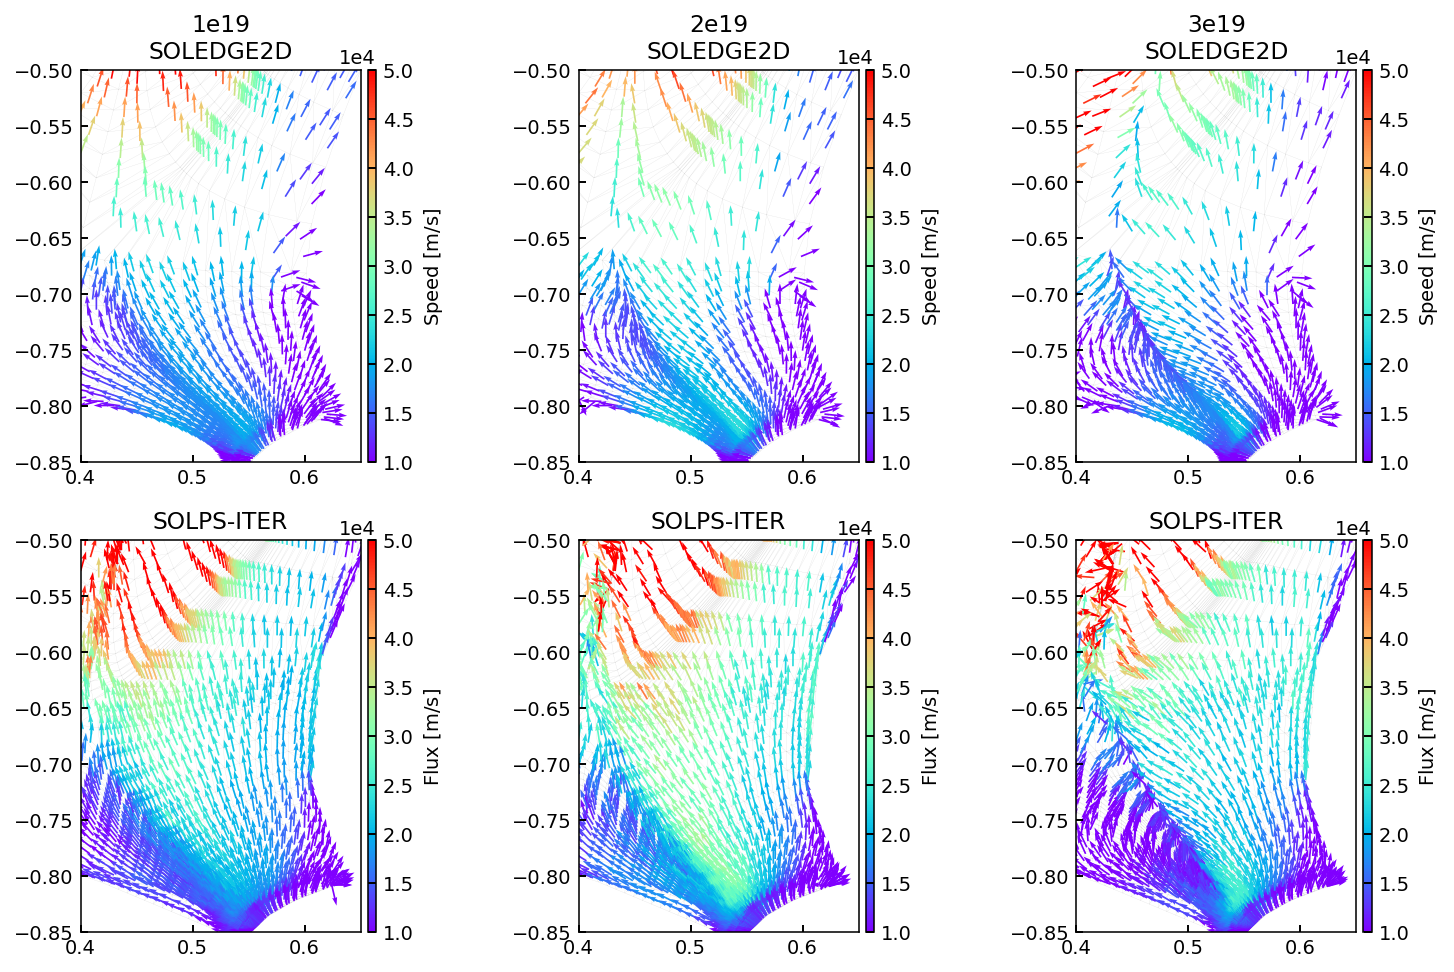

In [19]:
densities = ["1e19", "2e19", "3e19"]

fig, axes = plt.subplots(2,3, figsize = (13,8))
    # fig.suptitle(dens)

for i, dens in enumerate(densities):

    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi"])
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])

    kwargs = dict(
        vmin = 1e4,
        vmax = 5e4,
        logscale = False,
        width = 0.006,
        scale_mult = 1.1,
        gridcolor = "lightgrey",
        gridwidth = 0.1,
        cmap = "rainbow"
    )

    slc.plot_neutral_vectors(ax = axes[0,i], flux = False, **kwargs)
    spc.plot_neutral_vectors(ax = axes[1,i], flux = False, **kwargs)

    axes[0,i].set_title(f"{dens}\nSOLEDGE2D")
    axes[1,i].set_title("SOLPS-ITER")

    for ax in axes.flatten():
        ax.set_aspect("equal")
        ax.set_xlim(0.4, 0.65)
        ax.set_ylim(-0.85, -0.5)

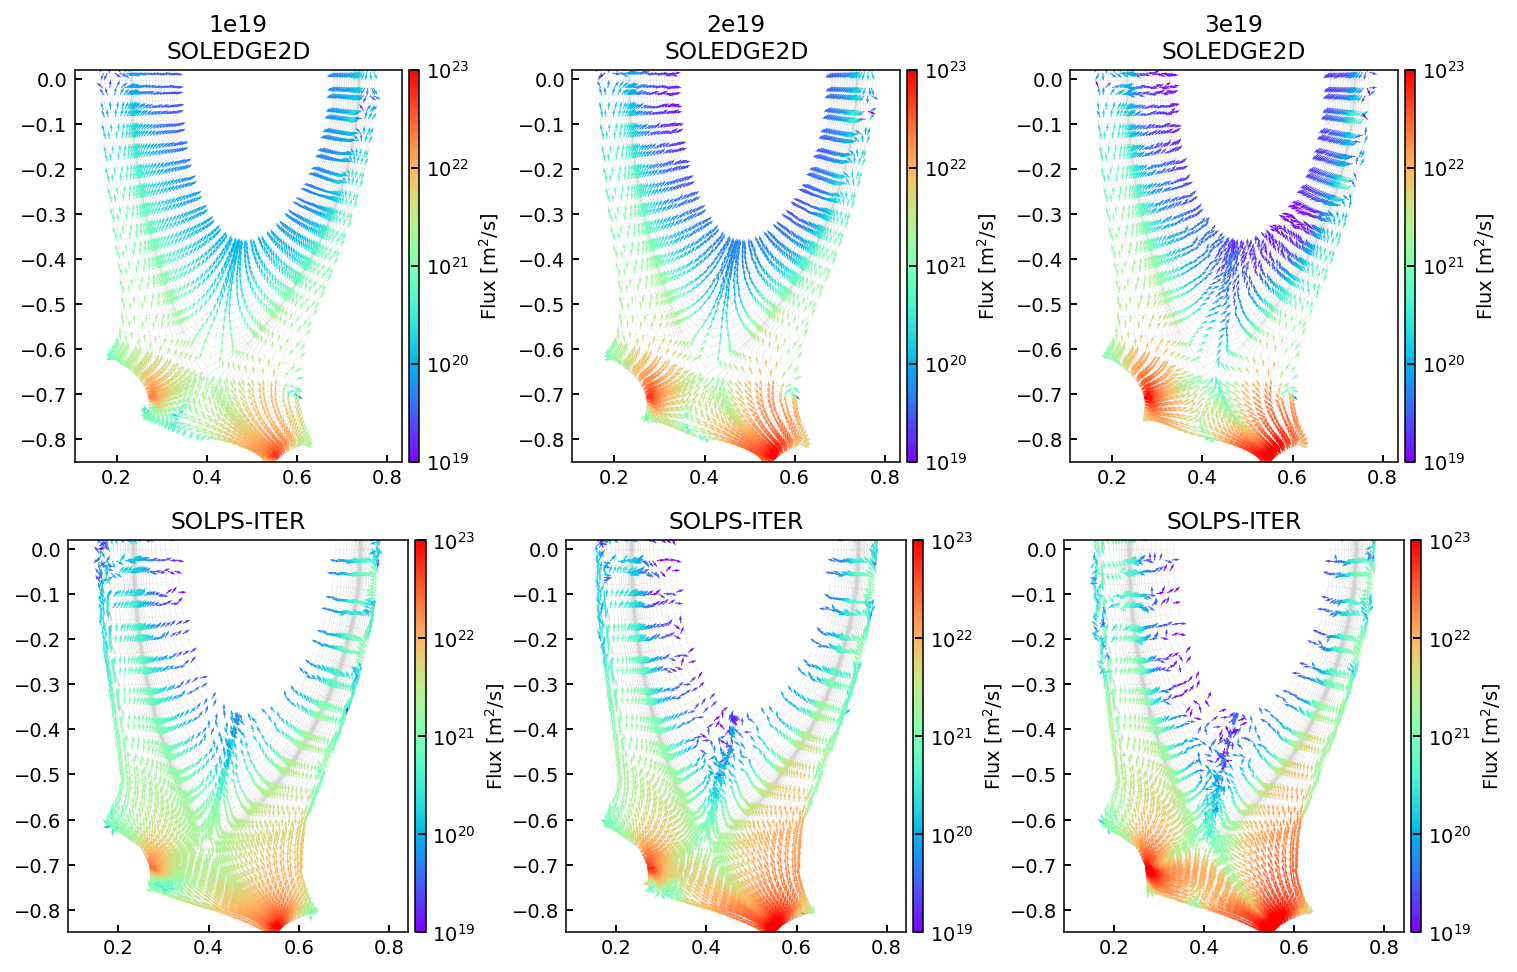

In [232]:
dens = "1e19"

densities = ["1e19", "2e19", "3e19"]

fig, axes = plt.subplots(2,3, figsize = (13,8))
    # fig.suptitle(dens)

for i, dens in enumerate(densities):

    spc = SOLPScase(solpscases[f"tightwall_noD2_{dens}_zerophi_spectra"])
    slc = SOLEDGEcase(path = soledgecases[f"tightwall_{dens}"])

    kwargs = dict(
        vmin = 1e19,
        vmax = 1e23,
        logscale = True,
        width = 0.003,
        scale_mult = 1.1,
        gridcolor = "lightgrey",
        gridwidth = 0.1,
        cmap = "rainbow"
    )

    slc.plot_neutral_vectors(ax = axes[0,i], flux = True, **kwargs)
    spc.plot_neutral_vectors(ax = axes[1,i], flux = True, **kwargs)

    axes[0,i].set_title(f"{dens}\nSOLEDGE2D")
    axes[1,i].set_title("SOLPS-ITER")

    for ax in axes.flatten():
        ax.set_aspect("equal")
        ax.set_ylim(-0.85, 0.02)

In [ ]:
fort46_path = os.path.join(solpscases["tightwall_noD2_2e19_zerophi_spectra"], "fort.46.pkl")
with open(fort46_path, "rb") as f:
    f46 = pickle.load(f)
    
triangles_path = os.path.join(solpscases["tightwall_noD2_2e19_zerophi_spectra"], "triangle_mesh.pkl")
with open(triangles_path, "rb") as f:
    triangles = pickle.load(f)
    

In [153]:
f46.keys()

dict_keys(['ntri', 'pdena', 'pdenm', 'pdeni', 'pdenan', 'edena', 'edenm', 'edeni', 'tdena', 'tdenm', 'tdeni', 'pdenn', 'edenn', 'tdenn', 'vxdena', 'vxdenm', 'vxdeni', 'vydena', 'vydenm', 'vydeni', 'vzdena', 'vzdenm', 'vzdeni', '__comments__'])

In [157]:
U.max()

np.float64(0.5372312747052)

(-0.85, 0.02)

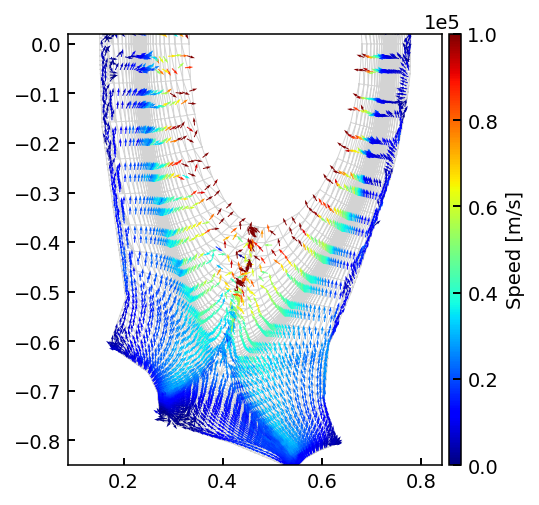

In [ ]:
fig, ax = plt.subplots()

normalise_arrows = True
vmin = 0
vmax = 1e5
logscale = False

nodes = triangles["nodes"]
cells = triangles["cells"]
triang = tri.Triangulation(nodes[:,0], nodes[:,1], cells)

U = f46["vxdena"] / f46["pdena"] / (2*constants("mass_p"))
V = f46["vydena"] / f46["pdena"] / (2*constants("mass_p"))
speed = np.hypot(U, V)

tri_coords = nodes[cells]
centroids = tri_coords.mean(axis=1)
px = centroids[:, 0]
py = centroids[:, 1]

# normalize vectors to unit length for plotting
# avoid division by zero
scale = 5e4
if normalise_arrows:
    eps = 1e-16
    U = U / (speed + eps) * scale
    V = V / (speed + eps) * scale
    
# set up log normalization (avoid zeros by clipping)
if vmin is None:
    vmin = max(speed.min(), 1e-3)  # lower bound >0
if vmax is None:
    vmax = speed.max()
    
if logscale:
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    cbar_formatter = LogFormatterSciNotation(base=10)
else:
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_formatter = None

if ax is None:
    fig, ax = plt.subplots(figsize = (5,15))

ax.triplot(triang, color = "lightgrey", lw = 0.5)


Q = ax.quiver(px, py, U, V, speed,
                angles='xy',        # no automatic rotation
                scale_units='xy',   # scale in data units
                cmap = "jet",
                norm = norm,
                scale=3e6,            # if vectors are already in desired length
                width=0.0025        # adjust arrow thickness
                )

# create a colorbar whose height matches ax
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar = plt.colorbar(Q, cax=cax, format=cbar_formatter)
cbar.set_label('Speed [m/s]')
cbar.ax.yaxis.set_tick_params(which='both', length=4)

ax.set_aspect("equal")
ax.set_ylim(-0.85, 0.02)

In [136]:
U

array([[-6.737411e-06],
       [-6.806326e-06],
       [ 4.388750e-06],
       ...,
       [-3.212280e-07],
       [ 4.565741e-06],
       [-5.836812e-08]], shape=(8783, 1))

In [137]:
triangles["cells"]

array([[ 287,  288,  703],
       [ 633,  634,  704],
       [ 395,  396,  705],
       ...,
       [4593,   90,   26],
       [4663,  491,  374],
       [4661,  584,  487]], shape=(8783, 3), dtype=int32)

In [ ]:
self = SOLPScase(path = solpscases["tightwall_noD2_2e19_zerophi_spectra"])
self.params

# 2D plots of atom pressure

6.234757453586943 2370.1488797361403


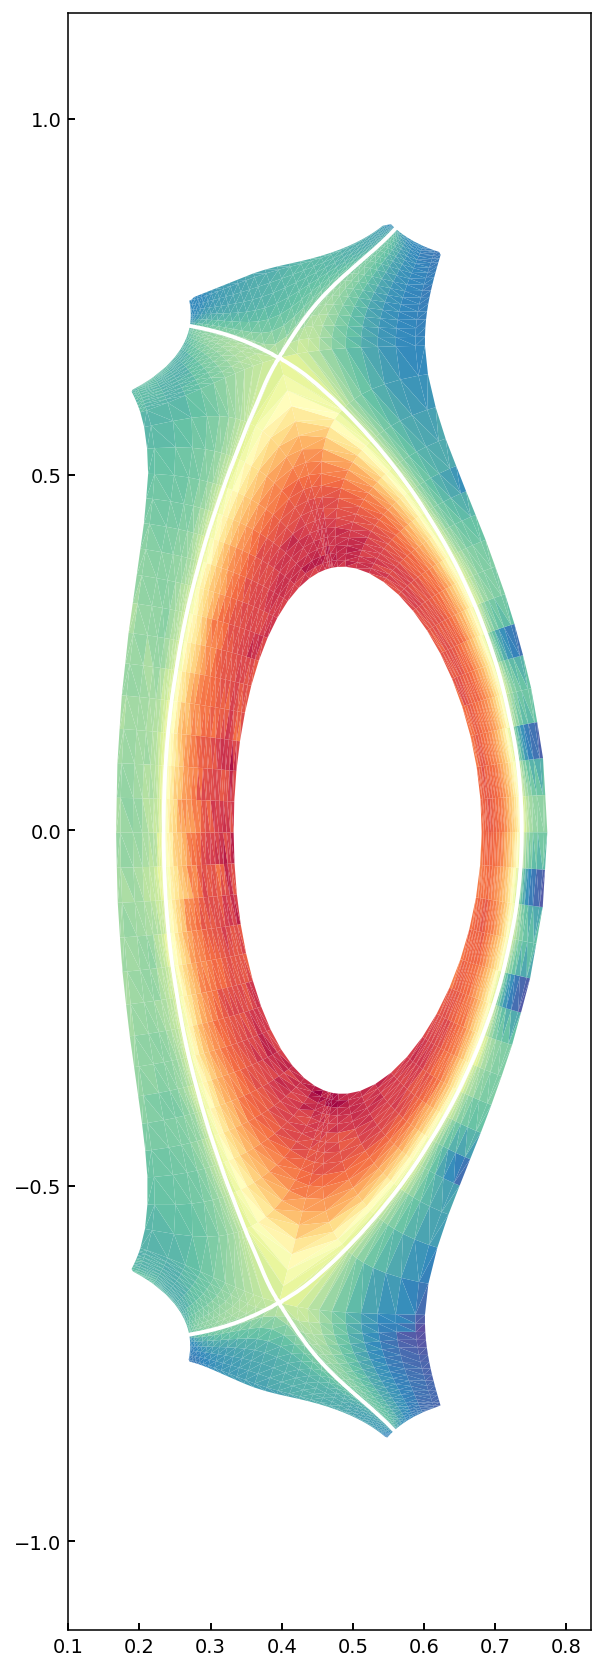

In [115]:
from soledge.wrapper_class import SOLEDGEcase

fig, ax = plt.subplots(figsize = (5, 15))
slc = SOLEDGEcase(soledgecases["tightwall_3e19"])
slc.plot_2d(param = "Ta", fig = fig, ax = ax)

In [191]:
slc.get_data("Pa")

array([0.0285809 , 0.03381897, 0.05196807, ..., 1.0337339 , 1.70586095,
       0.8591942 ], shape=(5707,))

54165865329221.94 8.851316185013708e+18
None
0.00925576236819821 35.93396445268527
None


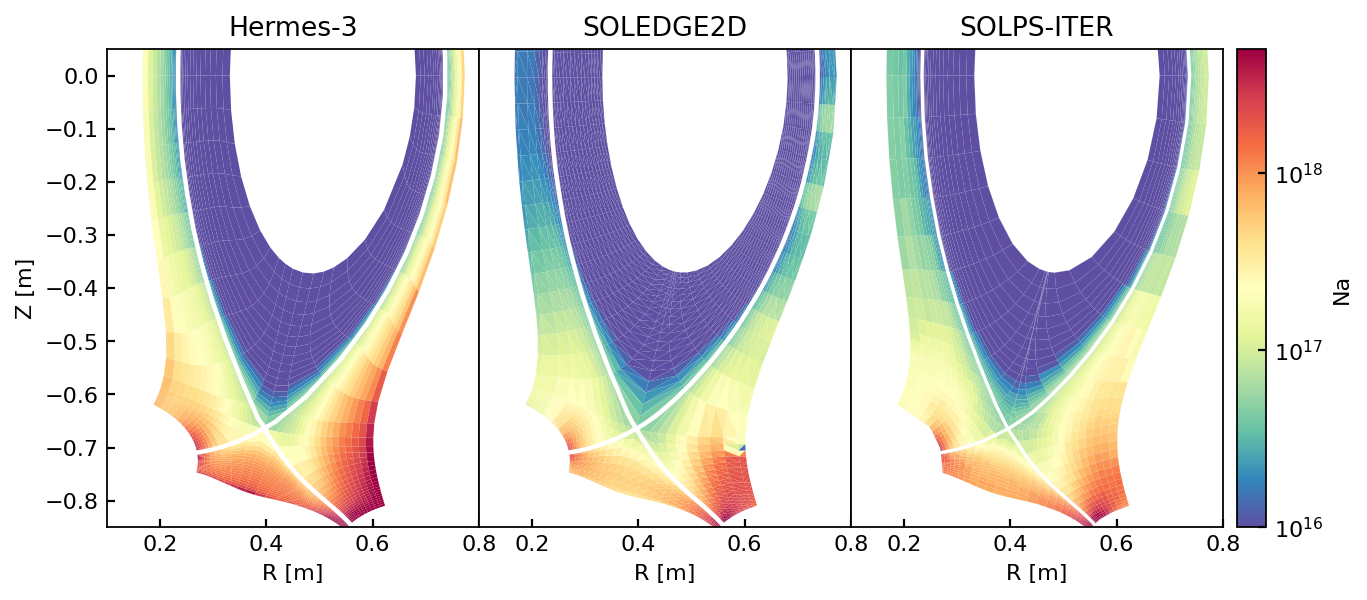

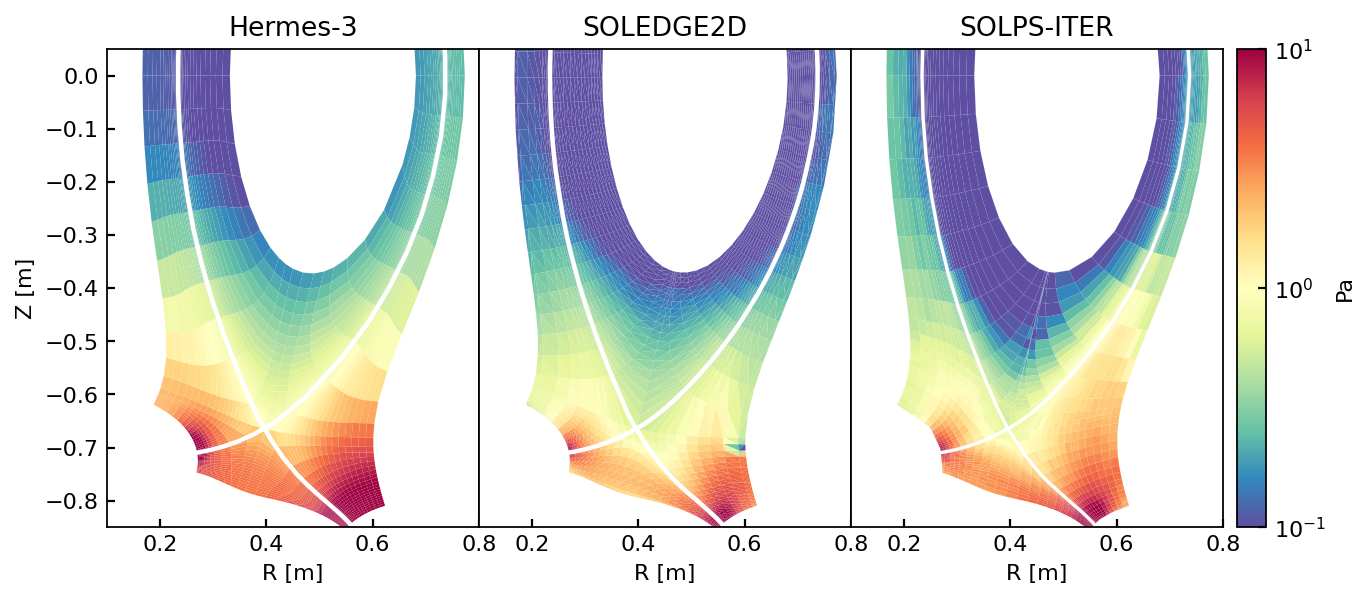

In [ ]:
dens = "2e19"

cs[dens].ds["Na"] = cs[dens].ds["Nd"]
cs[dens].ds["Pa"] = cs[dens].ds["Pd"]

cases = [
        {"name" : "Hermes-3", "code" : "hermes", "ds" : cs[dens].ds.isel(t=-1)},
        {"name" : "SOLEDGE2D", "code":"soledge", "path" : soledgecases[f"tightwall_{dens}"]},
        {"name": "SOLPS-ITER", "code":"solps", "path" : solpscases[f'tightwall_noD2_{dens}_zerophi_spectra']}
    ]

settings = dict(
    logscale = True,
    dpi = 160,
    ylim = (-0.85, 0.05),
    xlim = (0.1, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r")

viewer_2d("Na", cases = cases, vmin = 1e16, vmax = 5e18, **settings)
viewer_2d("Pa", cases = cases, vmin = 0.1, vmax = 10, **settings)




## Top of tokamak

54165865329221.94 8.851316185013708e+18
None
0.00925576236819821 35.93396445268527
None


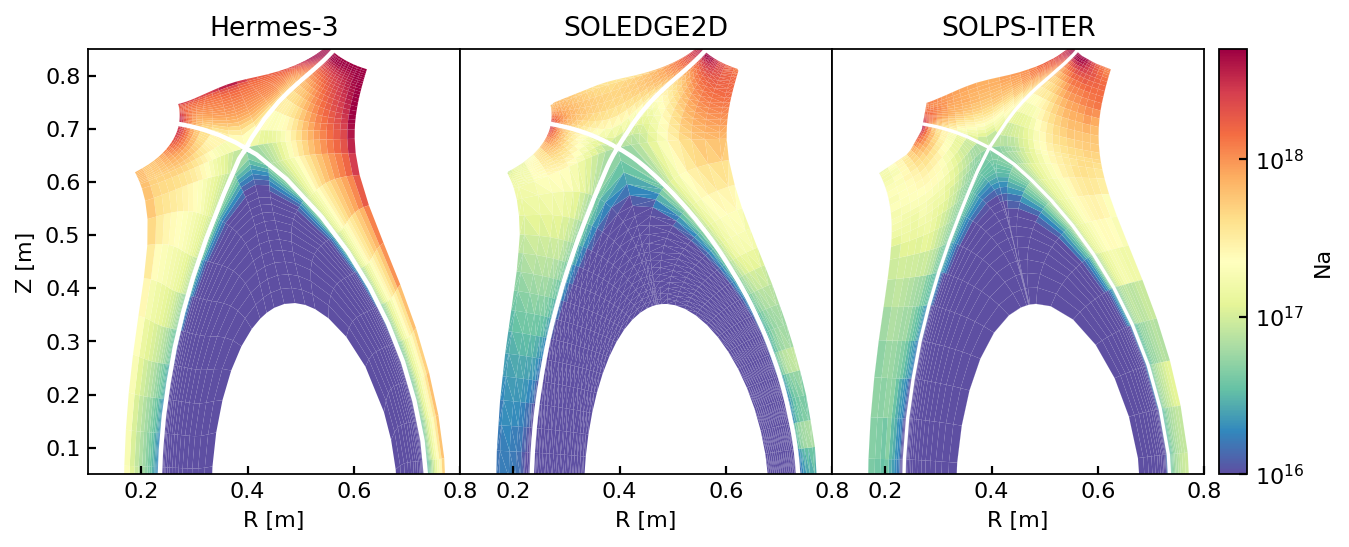

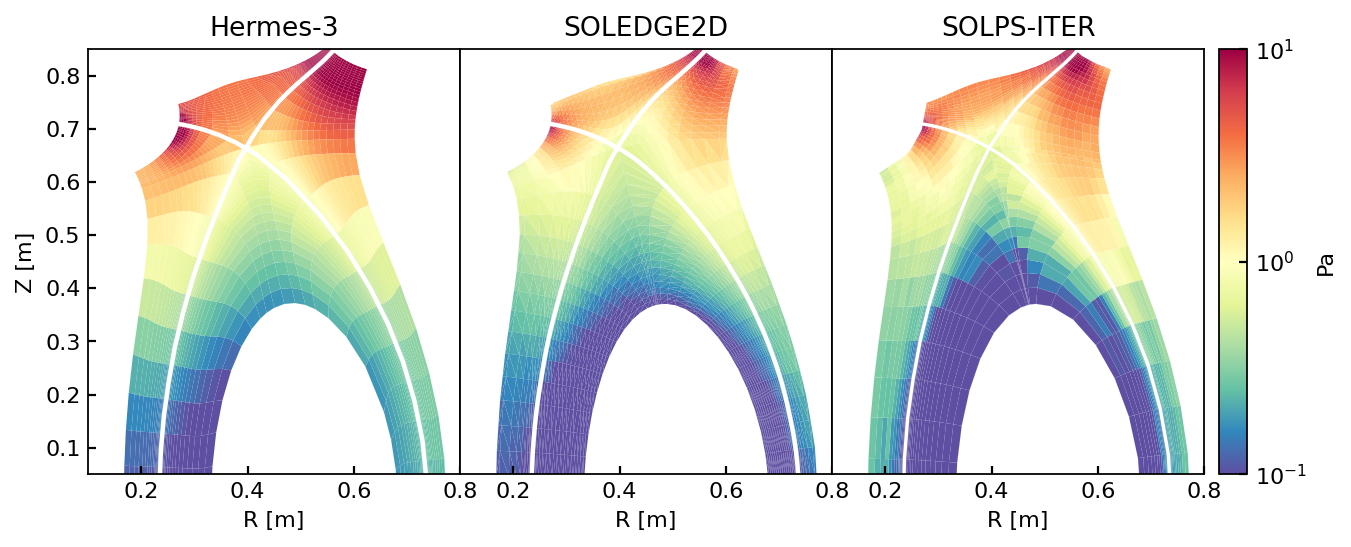

In [40]:
settings = dict(
    logscale = True,
    dpi = 160,
    ylim = (0.05, 0.85),
    xlim = (0.1, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r")

viewer_2d("Na", cases = cases, vmin = 1e16, vmax = 5e18, **settings)
viewer_2d("Pa", cases = cases, vmin = 0.1, vmax = 10, **settings)

# Multiple fieldlines

In [84]:
hrcase = hr["2e19"]
omp = get_1d_radial_data(hrcase.ds, params = ["Te"], region = "omp")
omp = omp[omp["Srad"] >= 0]
Rpos_hr = omp["Srad"].values * 100

dfs_hr = {}
for i, R in enumerate(Rpos_hr):
    df = get_1d_poloidal_data(hrcase.ds, params = ["Nd", "Pd"], region = "outer_lower", sepadd = i)
    df = df.rename(columns = {"Nd" : "Na", "Pd" : "Pa"})
    dfs_hr[R] = df
    
    # ax.plot(df["Spar"], df["Nd"])
    # ax.set_yscale("log")
# df

In [104]:
spcase = SOLPScase(solpscases["tightwall_noD2_2e19_zerophi_spectra"])

omp = spcase.get_1d_radial_data(["Te", "Ne"], region = "omp")
omp = omp[omp["dist"] >= 0]
Rpos_sp = omp["dist"].values * 100

dfs_sp = {}
for i, R in enumerate(Rpos_sp):
    dfs_sp[R] = spcase.get_1d_poloidal_data(params = ["Na", "Pa"], region = "outer_lower", sepadd = i)

In [107]:
slcase = SOLEDGEcase(path = soledgecases["tightwall_2e19"])

omp = slcase.get_1d_radial_data(["Te", "Ne"], theta_line = 0)
omp = omp[omp["dist"] >= 0]
Rpos_sl = omp["dist"].values * 100

dfs_sl = {}
for i, R in enumerate(Rpos_sl):
    dfs_sl[i] = slcase.get_1d_poloidal_data(params = ["Na", "Pa"], region = "outer_lower", d_from_sep = R/100, parallel_length = True)
    
#### WARNING THIS ONE IS INDEX NOT VALUE

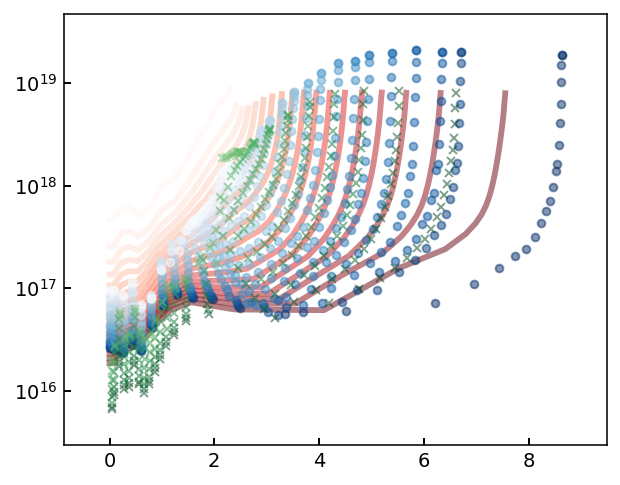

In [110]:
fig, ax = plt.subplots()


colors = plt.get_cmap('Reds_r')(np.linspace(0, 1, len(Rpos_hr)))
for i, R in enumerate(Rpos_hr):
    df = dfs_hr[R]
    ax.plot(df["Spar"], df["Na"], label = f"{R:.1f} cm", lw = 3, alpha = 0.5, color = colors[i])
    
colors = plt.get_cmap('Blues_r')(np.linspace(0, 1, len(Rpos_sp)))
for i, R in enumerate(Rpos_sp):
    df = dfs_sp[R]
    ax.plot(df["Spar"], df["Na"], label = f"{R:.1f} cm", lw = 0, alpha = 0.5, marker = "o", ms = 4, color = colors[i])
    
colors = plt.get_cmap('Greens_r')(np.linspace(0, 1, len(Rpos_sp)))
for i, R in enumerate(Rpos_sl):
    df = dfs_sl[i] ## WARNING THIS IS DIFFERENT
    ax.plot(-df["dist"], df["Na"], label = f"{R:.1f} cm", lw = 0, alpha = 0.5, marker = "x", ms = 4, color = colors[i])
    
ax.set_yscale("log")

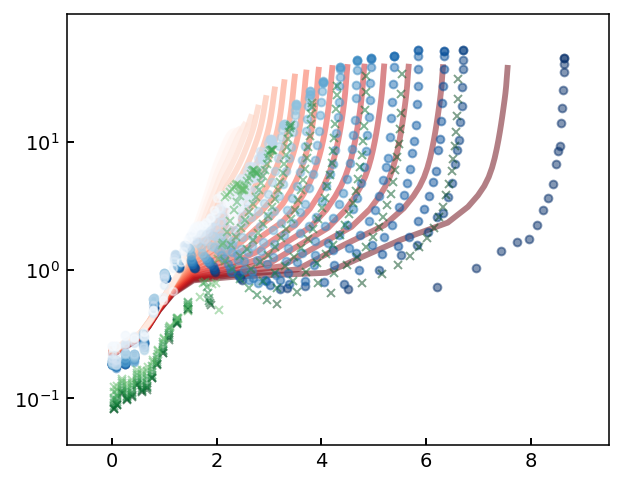

In [111]:
fig, ax = plt.subplots()


colors = plt.get_cmap('Reds_r')(np.linspace(0, 1, len(Rpos_hr)))
for i, R in enumerate(Rpos_hr):
    df = dfs_hr[R]
    ax.plot(df["Spar"], df["Pa"], label = f"{R:.1f} cm", lw = 3, alpha = 0.5, color = colors[i])
    
colors = plt.get_cmap('Blues_r')(np.linspace(0, 1, len(Rpos_sp)))
for i, R in enumerate(Rpos_sp):
    df = dfs_sp[R]
    ax.plot(df["Spar"], df["Pa"], label = f"{R:.1f} cm", lw = 0, alpha = 0.5, marker = "o", ms = 4, color = colors[i])
    
colors = plt.get_cmap('Greens_r')(np.linspace(0, 1, len(Rpos_sp)))
for i, R in enumerate(Rpos_sl):
    df = dfs_sl[i] ## WARNING THIS IS DIFFERENT
    ax.plot(-df["dist"], df["Pa"], label = f"{R:.1f} cm", lw = 0, alpha = 0.5, marker = "x", ms = 4, color = colors[i])
    
ax.set_yscale("log")